# 4.7.7. Exercises


In [1]:
from d2l import torch as d2l
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.nn import functional as F

##### 1. What could happen when we change the behavior of a search engine? What might the users do? What about the advertisers?

**当我们改变搜索引擎的行为时会发生什么？用户可能会怎么做？广告商呢？**


答：如果这些变化导致更准确和相关的搜索结果，用户可能会有更好的体验，并更容易找到他们所寻找的信息。另一方面，如果这些变化导致结果不够相关，用户可能会对搜索引擎的表现感到沮丧和不满。

广告商可能需要调整他们的广告策略、关键词和定位参数，以适应新的搜索引擎行为。如果这些变化导致广告表现下降，广告商可能会经历投资回报率（ROI）的减少，并可能重新考虑他们在该平台上的广告预算。


##### 2. Implement a covariate shift detector. Hint: build a classifier.

**实现一个协变量漂移检测器。提示：构建一个分类器。**


答：我可以混合两个数据集并给它们标记为 0/1。然后我使用 softmax 分类器来区分这两个数据集。如果测试准确率大于某个阈值，可能存在协变量转移。


val_acc: 0.4932999908924103


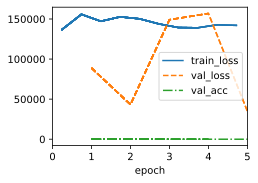

In [2]:
def accuracy(Y_hat, Y, averaged=True):
  """Compute the number of correct predictions."""
  Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
  preds = Y_hat.argmax(axis=1).type(Y.dtype)
  compare = (preds == Y.reshape(-1)).type(torch.float32)
  return compare.mean() if averaged else compare


class SameDataSet(d2l.DataModule):
  def __init__(self, batch_size=64, resize=(28, 28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
    dataset1 = torchvision.datasets.FashionMNIST(
      root=self.root, train=True, transform=trans, download=True
    )
    dataset2 = torchvision.datasets.FashionMNIST(
      root=self.root, train=False, transform=trans, download=True
    )

    random_rows_indices = torch.randperm(dataset1.data.size(0))
    num_rows_to_select = dataset2.data.shape[0] // 2

    self.train_X = torch.cat(
      (dataset1.data[random_rows_indices[:num_rows_to_select]], dataset2.data[:num_rows_to_select]),
      dim=0,
    ).type(torch.float32)
    self.train_y = torch.cat(
      (torch.ones(num_rows_to_select), torch.zeros(num_rows_to_select)), dim=0
    ).type(torch.int64)
    self.val_X = torch.cat(
      (
        dataset1.data[random_rows_indices[num_rows_to_select : 2 * num_rows_to_select]],
        dataset2.data[num_rows_to_select : 2 * num_rows_to_select],
      ),
      dim=0,
    ).type(torch.float32)
    self.val_y = torch.cat(
      (torch.ones(num_rows_to_select), torch.zeros(num_rows_to_select)), dim=0
    ).type(torch.int64)
    self.train = torch.utils.data.TensorDataset(self.train_X, self.train_y)
    self.val = torch.utils.data.TensorDataset(self.val_X, self.val_y)

  def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(
      data, self.batch_size, shuffle=train, num_workers=self.num_workers
    )


data = SameDataSet()
model = d2l.SoftmaxRegression(num_outputs=2, lr=0.1)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
y_hat = model.net(data.val_X)
print(f"val_acc: {accuracy(y_hat, data.val_y)}")

val_acc: 0.9794999957084656


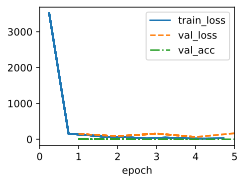

In [3]:
class DifferentDataSet(d2l.DataModule):
  def __init__(self, batch_size=64, resize=(28, 28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
    dataset1 = torchvision.datasets.FashionMNIST(
      root=self.root, train=True, transform=trans, download=True
    )
    dataset2 = torchvision.datasets.MNIST(
      root=self.root, train=False, transform=trans, download=True
    )

    random_rows_indices = torch.randperm(dataset1.data.size(0))
    num_rows_to_select = dataset2.data.shape[0] // 2

    self.train_X = torch.cat(
      (dataset1.data[random_rows_indices[:num_rows_to_select]], dataset2.data[:num_rows_to_select]),
      dim=0,
    ).type(torch.float32)
    self.train_y = torch.cat(
      (torch.ones(num_rows_to_select), torch.zeros(num_rows_to_select)), dim=0
    ).type(torch.int64)
    self.val_X = torch.cat(
      (
        dataset1.data[random_rows_indices[num_rows_to_select : 2 * num_rows_to_select]],
        dataset2.data[num_rows_to_select : 2 * num_rows_to_select],
      ),
      dim=0,
    ).type(torch.float32)
    self.val_y = torch.cat(
      (torch.ones(num_rows_to_select), torch.zeros(num_rows_to_select)), dim=0
    ).type(torch.int64)
    self.train = torch.utils.data.TensorDataset(self.train_X, self.train_y)
    self.val = torch.utils.data.TensorDataset(self.val_X, self.val_y)

  def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(
      data, self.batch_size, shuffle=train, num_workers=self.num_workers
    )


data = DifferentDataSet()
model = d2l.SoftmaxRegression(num_outputs=2, lr=0.1)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
y_hat = model.net(data.val_X)
print(f"val_acc: {accuracy(y_hat, data.val_y)}")

在网上找到其他方法，[链接](https://www.linkedin.com/pulse/how-detect-multivariate-covariate-shift-machine-learning-krishna-yogi-v3fxc/)

- 比较摘要统计数据，如均值和中位数。
- 使用分布图进行视觉检查。
- 进行假设检验。
- 使用巴塔查里亚距离或科尔莫戈罗夫-斯米尔诺夫（KS）检验等技术测量训练分布和生产分布之间的距离。


##### 3. Implement a covariate shift corrector.

**实现协变量偏移校正器。**


答：协变量偏移通常指的是在训练数据和测试数据中，输入特征的分布发生了变化，但输出的条件分布保持不变的情况，重要性加权可以在一定程度上校正这种偏移。我们需要根据概率的比率重新加权每个数据示例

$$\beta_i = \frac{p(x_i)}{q(x_i)}$$

然后我们使用在问题 2 中训练的分类器。如果我们得到 $Model(x_i)=(o_1,o_2)$ ，$\beta_i = \frac{exp(o_2)}{exp(o_1)}$


In [8]:
class CorrFashionMNIST(d2l.DataModule):
  def __init__(self, detector, batch_size=64, resize=(28, 28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
    train = torchvision.datasets.FashionMNIST(
      root=self.root, train=True, transform=trans, download=True
    )
    val = torchvision.datasets.FashionMNIST(
      root=self.root, train=False, transform=trans, download=True
    )
    self.train_X = train.data.type(torch.float32)
    self.train_y = train.targets.type(torch.int64)
    self.train_weight = self.stat_weight(self.train_X)
    self.val_X = val.data.type(torch.float32)
    self.val_y = val.targets.type(torch.int64)
    self.val_weight = self.stat_weight(self.val_X)
    self.train = torch.utils.data.TensorDataset(self.train_weight, self.train_X, self.train_y)
    self.val = torch.utils.data.TensorDataset(self.val_weight, self.val_X, self.val_y)

  def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(
      data, self.batch_size, shuffle=train, num_workers=self.num_workers
    )

  def stat_weight(self, X):
    h = self.detector(X)
    weight = torch.exp(h[:, 1] - h[:, 0])
    weight[weight == torch.inf] = 10
    weight = weight.detach()
    return weight


class CorrSoftmaxRegression(d2l.Classifier):
  def __init__(self, num_outputs, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_outputs))

  def forward(self, X):
    return self.net(X)

  def loss(self, y_hat, y, weight=None):
    y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
    y = y.reshape((-1,))
    l = F.cross_entropy(y_hat, y, reduction="none")
    if weight is not None:
      l = l * weight
    return l.mean()

  def training_step(self, batch, plot_flag=True):
    y_hat = self(*batch[1:-1])
    l = self.loss(y_hat, batch[-1], batch[0])
    if plot_flag:
      self.plot("acc", self.accuracy(y_hat, batch[-1]), train=True)
    return l

  def validation_step(self, batch, plot_flag=True):
    y_hat = self(*batch[1:-1])
    l = self.loss(y_hat, batch[-1])
    if plot_flag:
      self.plot("acc", self.accuracy(y_hat, batch[-1]), train=False)
    return l

acc:0.10


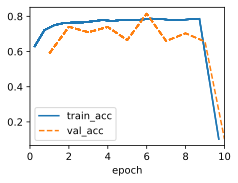

In [9]:
data = CorrFashionMNIST(detector=model, batch_size=256)
model2 = CorrSoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model2, data)
y_hat = model2.net(data.val_X)
print(f"acc:{model2.accuracy(y_hat, data.val_y):.2f}")

##### 4. Besides distribution shift, what else could affect how the empirical risk approximates the risk?

**除了分布转移，还有什么其他因素可能影响经验风险如何近似风险？**


答：训练数据集的大小和模型复杂性。

资料：<https://pandalab.me/archives/environment_and_distribution_shift>
